In [152]:
import pickle
import json
from random import randint
from tqdm import tqdm

In [97]:
def load_data(filename):
    with open(f"{filename}.pkl", "rb") as f:
        data = pickle.load(f)
    print("Loaded data!")
    return data
        
def save_data(data, filename):
    with open(f"{filename}.pkl", "wb") as f:
        pickle.dump(data, f)
        
def export_to_json(data):
    with open('matches.json', 'w') as json_file:
      json.dump(data, json_file)

In [203]:
data, players = load_data("matches"), load_data("player_table")
match_ids = list(data.keys())

Loaded data!
Loaded data!


In [153]:
def getRandomMatch():
    return data[match_ids[randint(0, 1919)]]

def printInnings():
    

In [154]:
# for m_id, details in data.items():
from espncricinfo.match import Match
m = getRandomMatch()
for k, v in players[m['team_1_players'][0]].items():
    if v is None: v = ""
    print(f"{k.upper():<20}: {v:<10}")

['4176', '2119', '2230', '8876', '6256', '4382', '12049', '7445', '6973', '10130', '2101']
ALPHA_NAME          : GILCHRIST,AC
BATTING_HAND        : left-hand batsman
BATTING_STYLE       : lhb       
BATTING_STYLE_LONG  : left-hand bat
BOWLING_HAND        : right-arm bowler
BOWLING_PACESPIN    : spin bowler
BOWLING_STYLE       : ob        
BOWLING_STYLE_LONG  : right-arm offbreak 
CARD_LONG           : AC Gilchrist
CARD_QUALIFIER      :           
CARD_SHORT          : Gilchrist 
DOB                 : 1971-11-14
KNOWN_AS            : Adam Gilchrist
MOBILE_NAME         : Gilchrist 
PLAYER_ID           : 4176      
PLAYER_PRIMARY_ROLE : wicketkeeper batsman
PLAYER_STYLE_ID     : 7         
PLAYER_TYPE         : 1         
PLAYER_TYPE_NAME    : player    


In [155]:
from collections import defaultdict
teams = defaultdict(int)
for i, match in data.items():
    teams[match['team1']] += 1
    teams[match['team2']] += 1
counts = sorted(list(teams.items()), key=lambda x:-x[1])
for i, (k, v) in enumerate(counts):
    print(f'{i+1:<2} - {k:<15} : {v:>5}')

1  - India           :   397
2  - Sri Lanka       :   379
3  - Australia       :   359
4  - England         :   334
5  - Pakistan        :   317
6  - West Indies     :   303
7  - South Africa    :   296
8  - New Zealand     :   294
9  - Bangladesh      :   261
10 - Zimbabwe        :   241
11 - Ireland         :   143
12 - Afghanistan     :   122
13 - Scotland        :    94
14 - Kenya           :    65
15 - Netherlands     :    52
16 - Canada          :    51
17 - U.A.E.          :    41
18 - Hong Kong       :    22
19 - P.N.G.          :    22
20 - Bermuda         :    17
21 - Asia XI         :     7
22 - Africa XI       :     6
23 - Nepal           :     6
24 - Oman            :     5
25 - ICC World XI    :     4
26 - Namibia         :     1
27 - U.S.A.          :     1


In [156]:
def extract_over_details(innings):
    summaries = [ball for ball in innings if 'END OF' in ball[0]]
    balls = [ball for ball in innings if 'END OF' not in ball[0]]
    return summaries, balls

In [210]:
import re
pattern = '[1-4]?[0-9]\.[1-7]'
def findActualBall(ball):
    for i, item in enumerate(ball):
        if bool(re.search(pattern, item)):
            return ball[i:i+3]

def checkBallData(innings):
    num = 0
    for ball in innings:
        if not bool(re.search(pattern, ball[0])):
#             print(ball)
#             print(findActualBall(ball))
            num += 1
    return num
            
numBallsRogue = defaultdict(int)
for i, m in data.items():
    comms1 = m['commentary']['innings1']
    comms2 = m['commentary']['innings2']
    
    summaries1, balls1= extract_over_details(comms1)
    summaries2, balls2 = extract_over_details(comms2)
    
    numBallsRogue[i] += checkBallData(balls1)
    numBallsRogue[i] += checkBallData(balls2)

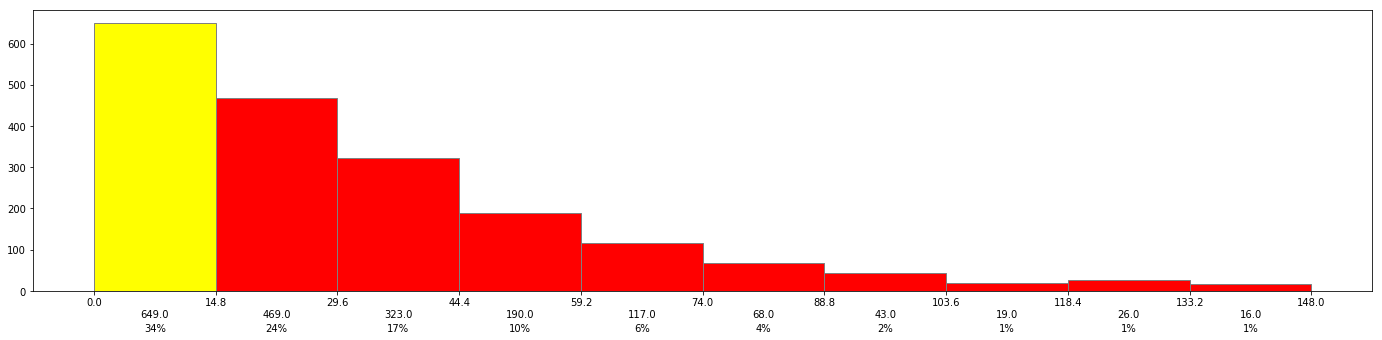

In [218]:
import numpy as np
from matplotlib.ticker import FormatStrFormatter

data_hist = np.random.randn(82)
fig, ax = plt.subplots(figsize=(24,5))
counts, bins, patches = ax.hist(list(numBallsRogue.values()), facecolor='yellow', edgecolor='gray')

# Set the ticks to be at the edges of the bins.
ax.set_xticks(bins)
# Set the xaxis's tick labels to be formatted with 1 decimal place...
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))

# Change the colors of bars at the edges...
twentyfifth, seventyfifth = np.percentile(data_hist, [25, 75])
for patch, rightside, leftside in zip(patches, bins[1:], bins[:-1]):
    if rightside < twentyfifth:
        patch.set_facecolor('green')
    elif leftside > seventyfifth:
        patch.set_facecolor('red')

# Label the raw counts and the percentages below the x-axis...
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
for count, x in zip(counts, bin_centers):
    # Label the raw counts
    ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -18), textcoords='offset points', va='top', ha='center')

    # Label the percentages
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -32), textcoords='offset points', va='top', ha='center')


# Give ourselves some more room at the bottom of the plot
plt.subplots_adjust(bottom=0.1)
plt.show()

In [220]:
for m, count in numBallsRogue.items():
    if count > 120:
        print(data[m]['commentary']['innings1'])
        print("\n * 2")
        print(data[m]['commentary']['innings2'])
        break

[["1.45pm Welcome back. Here come Gilchrist and Hayden, needing five an over, which should be comfortable on this track. Andrew Miller reckons 247 is a winning total. Let's find out shall we? It'll be James Anderson to take the new ball, a cricket ball, and not the beach ball that's blown onto the pitch. Here we go", "And that caps a brilliant performance and comeback from Australia. England were going building nicely with Ian Bell and Kevin Pietersen at the crease, but Hogg's fine spell stifled their momentum before the seamers came back and cut through the middle order. Shaun Tait bowled a magnificent couple of spells; straight, aggressive and never let up in his pace, he was Ponting's Brett Lee today. A terrific effort. Join us in 40 minutes for Australia's response.", '49.5', 'W', 'McGrath to Anderson, OUT, full, swinging into Anderson who completely misreads the line. McGrath roars his appeal and up goes the finger', 'JM Anderson lbw b McGrath 0 (2m 1b 0x4 0x6) SR: 0.00'], ['49.4'